Data Analysis Pipeline:


*  Clone the repo to carry the dependencies over and to invoke imagene.py.
*  Import all necessary modules.


*   Simulate data for ancient and moderate strength selection selrange = seq 0 300 300 / timerange = 0.1 100kya
*   Build and compile baseline model.


*   Train model on training data and gather metrics.

*   Test trained network on unseen data.
*  
This notebook seeks to utilise the optimsied hyperpamaters achived by bayseian optimisation where optimisation was done on 5 batches of data













In [1]:
# Cloning the GitHub repository
!git clone https://github.com/Djinho/EvoNet-CNN-Insight.git

# Change directories into the specified directory
%cd EvoNet-CNN-Insight/Opt_1/Recent_Moderate



Cloning into 'EvoNet-CNN-Insight'...
remote: Enumerating objects: 2864, done.
remote: Counting objects: 100% (737/737), done.
remote: Compressing objects: 100% (420/420), done.
remote: Total 2864 (delta 368), reused 653 (delta 316), pack-reused 2127
Receiving objects: 100% (2864/2864), 4.74 GiB | 31.77 MiB/s, done.
Resolving deltas: 100% (754/754), done.
Updating files: 100% (434/434), done.
/content/EvoNet-CNN-Insight/Opt_1/Recent_Moderate


In [2]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import arviz

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, optimizers



# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

from sklearn.model_selection import train_test_split


import itertools
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, auc
import pydot  # Optional, but required by keras to plot the model

In [3]:
%run -i ../../ImaGene.py

ImaGene uses msms to run simulations for training. Use ../generate_dataset.sh with ../params.txt (modify as needed).

 simulates 200,000 loci (80kbp) under neutral evolution or positive selection (1.5% selection coefficient). Mutation rate: 1.5e-8, recombination rate: 1e-8. Model follows Marth et al. 2004, sampling 198 chromosomal copies.

Specify directories for msms and simulation storage, then run the command. The script splits simulations into batches for training.

In [4]:
# if you wish to generate new training data, do not run otherwise
import subprocess
subprocess.call("bash ../../generate_dataset.sh params_Recent_Moderate.txt".split());

In [5]:
path = './'

In [6]:

path_sim = './'

In [7]:
file_sim = ImaFile(simulations_folder=path_sim + 'RM/Simulations1', nr_samples=198, model_name='Marth-3epoch-CEU');

Populate an ImaGene object by specifying the variable to estimate (selection_coeff_hetero) and the number of data points per class. Use 8000 data points per class as an example.

In [8]:
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=8000);

In [10]:
gene_sim.filter_freq(0.01);
gene_sim.sort('rows_freq');


In [11]:
gene_sim.resize((198, 192));

In [12]:
gene_sim.convert(flip=True);


shuffle images before using them for training network.


In [13]:
gene_sim.subset(get_index_random(gene_sim));

In [14]:
gene_sim.targets = to_binary(gene_sim.targets);

In [15]:
gene_sim.save(file=path + 'gene_sim.binary')

0

In [16]:
gene_sim = load_imagene(file=path + 'gene_sim.binary')

Build and compile the model.

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers

# Define the CNN model based on the optimal parameters for Scenario RM
model = models.Sequential([
    layers.Conv2D(filters=51, kernel_size=(3, 3), strides=1, activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=0.005199611594558027, l2=0.0008728201451207611),
                  padding='valid', input_shape=gene_sim.data.shape[1:]),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=53, kernel_size=(3, 3), strides=1, activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=0.005199611594558027, l2=0.0008728201451207611),
                  padding='valid'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=77, kernel_size=(3, 3), strides=1, activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=0.005199611594558027, l2=0.0008728201451207611),
                  padding='valid'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=1, activation='sigmoid')
])

# Compile the model with the specified learning rate
adam_optimizer = optimizers.Adam(learning_rate=2.37202138432884e-05)
model.compile(optimizer=adam_optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 190, 51)      510       
                                                                 
 max_pooling2d (MaxPooling2  (None, 98, 95, 51)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 93, 53)        24380     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 46, 53)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 44, 77)        36806     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 22, 77)        0

summary of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 190, 51)      510       
                                                                 
 max_pooling2d (MaxPooling2  (None, 98, 95, 51)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 93, 53)        24380     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 46, 53)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 44, 77)        36806     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 22, 77)        0

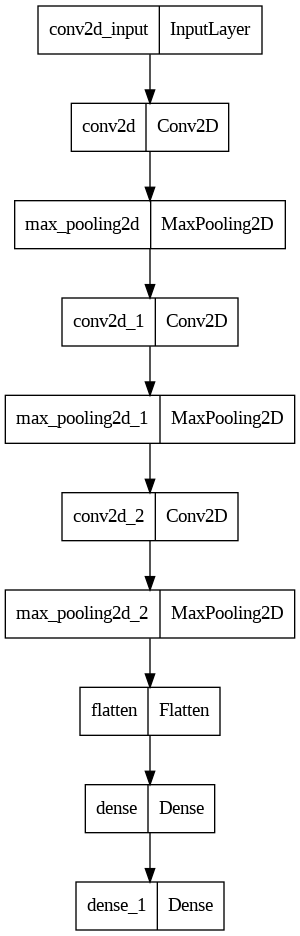

In [18]:
model.summary()
plot_model(model, path + 'net.binary.png')

In [19]:
net_LCT = ImaNet(name='[C51+P][C53+P][C77+P]+D128+D1')


In [20]:
from IPython.display import Javascript, display

def keep_alive():
    display(Javascript('''
        function ClickConnect() {
          console.log("Clicked on connect button to prevent timeout");
          document.querySelector("colab-toolbar-button#connect").click();
        }
        setInterval(ClickConnect, 60000); // 60 seconds
    '''))

keep_alive()


<IPython.core.display.Javascript object>

train batches from 1-9

1
113/113 [==============================] - 756s 7s/step - loss: 12.4290 - accuracy: 0.5393 - val_loss: 12.0033 - val_accuracy: 0.6350
2
113/113 [==============================] - 730s 6s/step - loss: 11.6095 - accuracy: 0.6031 - val_loss: 11.2223 - val_accuracy: 0.5063
3
113/113 [==============================] - 746s 7s/step - loss: 10.8503 - accuracy: 0.6408 - val_loss: 10.4995 - val_accuracy: 0.5263
4
113/113 [==============================] - 744s 7s/step - loss: 10.1502 - accuracy: 0.6396 - val_loss: 9.8186 - val_accuracy: 0.6513
5
113/113 [==============================] - 732s 6s/step - loss: 9.4994 - accuracy: 0.6792 - val_loss: 9.1748 - val_accuracy: 0.6938
6
113/113 [==============================] - 819s 7s/step - loss: 8.8822 - accuracy: 0.7297 - val_loss: 8.5842 - val_accuracy: 0.6913
7
113/113 [==============================] - 757s 7s/step - loss: 8.2992 - accuracy: 0.7399 - val_loss: 8.0228 - val_accuracy: 0.7325
8
113/113 [==============================] - 721s 6s/st

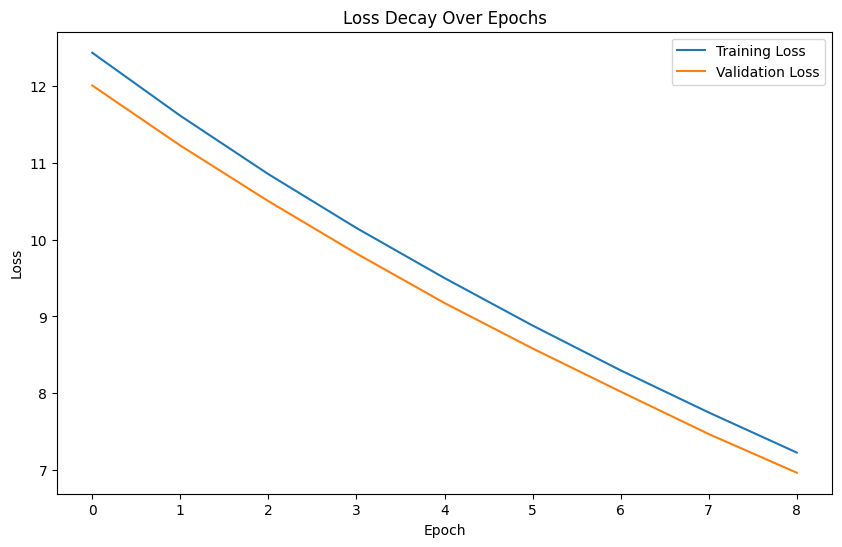

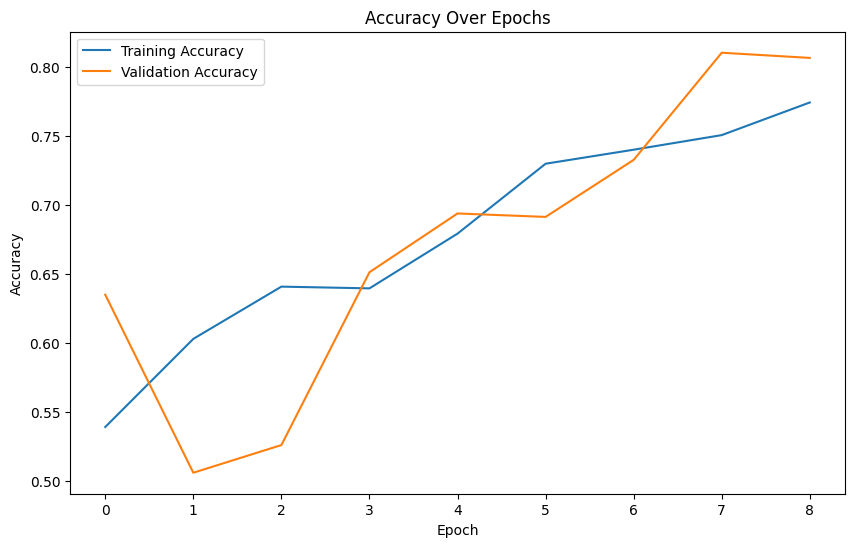

In [21]:
import csv


total_epochs = 0
losses = []
val_losses = []
accuracies = []
val_accuracies = []

i = 1
while i < 10:
    print(i)

    file_sim = ImaFile(simulations_folder=path_sim + 'RM/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=8000)

    gene_sim.filter_freq(0.01)
    gene_sim.sort('rows_freq')
    gene_sim.resize((198, 192))
    gene_sim.convert(flip=True)

    gene_sim.subset(get_index_random(gene_sim))
    gene_sim.targets = to_binary(gene_sim.targets)

    score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10)

    # Append the loss, validation loss, accuracy, and validation accuracy values for each epoch
    losses.extend(score.history['loss'])
    val_losses.extend(score.history['val_loss'])
    accuracies.extend(score.history['accuracy'])
    val_accuracies.extend(score.history['val_accuracy'])

    # Update the total number of epochs trained
    total_epochs += len(score.history['loss'])

    net_LCT.update_scores(score)

    i += 1

# Print the total number of epochs
print(f'Total epochs trained: {total_epochs}')

# Save the loss, validation loss, accuracy, and validation accuracy to a CSV file
with open('training_metrics.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
    for epoch in range(total_epochs):
        training_loss = losses[epoch] if epoch < len(losses) else ''
        validation_loss = val_losses[epoch] if epoch < len(val_losses) else ''
        training_accuracy = accuracies[epoch] if epoch < len(accuracies) else ''
        validation_accuracy = val_accuracies[epoch] if epoch < len(val_accuracies) else ''
        csvwriter.writerow([epoch + 1, training_loss, validation_loss, training_accuracy, validation_accuracy])

# Plot the loss and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(total_epochs), losses, label='Training Loss')
plt.plot(range(total_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Decay Over Epochs')
plt.legend()
plt.show()

# Plot the accuracy and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(total_epochs), accuracies, label='Training Accuracy')
plt.plot(range(total_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()


We can plot loss and validation accuracy during the training to check, for instance, for overfitting.

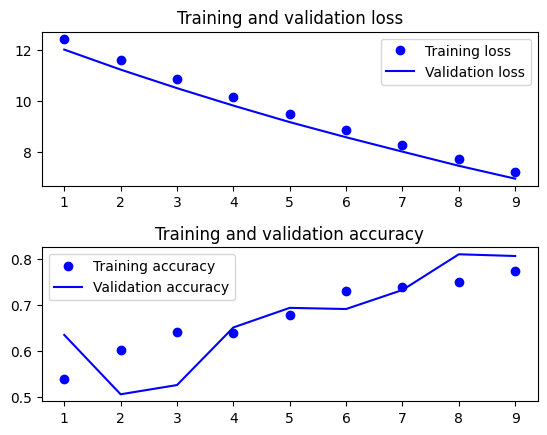

0

In [22]:
net_LCT.plot_train()

We save (and/or load) the final trained model.

In [29]:
model.save(path + 'model.RM.h5')

In [30]:
model = load_model(path + 'model.RM.h5')

You can also save the network itself (and load it).

In [31]:
net_LCT.save(path + 'net_LCT.RM');

In [32]:
net_LCT = load_imanet(path + 'net_LCT.RM')

Finally, we evaluate the training on the testing dataset, i.e. the last batch of simulated data.

In [33]:
i = 10
file_sim = ImaFile(simulations_folder=path_sim + 'RM/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
gene_sim_test = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=8000)

gene_sim_test.filter_freq(0.01)
gene_sim_test.sort('rows_freq')
gene_sim_test.resize((198, 192))
gene_sim_test.convert(flip=True)

rnd_idx = get_index_random(gene_sim_test)
gene_sim_test.subset(rnd_idx)

gene_sim_test.targets = to_binary(gene_sim_test.targets);

Let's report loss and accuracy on the testing set.

In [34]:

net_LCT.test = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=None, verbose=0)
print(net_LCT.test)  # it will report [loss, accuracy]



[6.98007869720459, 0.7910000085830688]


250/250 [==============================] - 222s 888ms/step


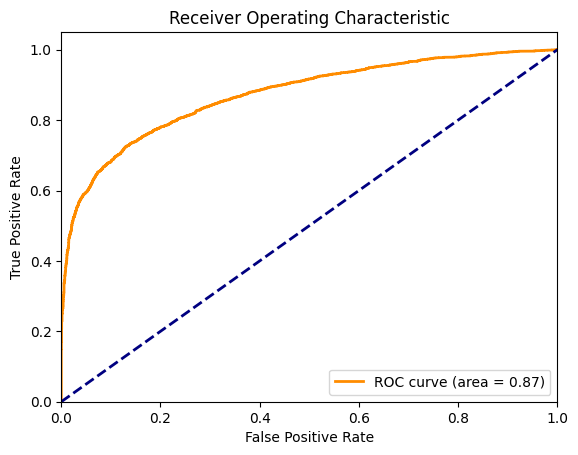

Sensitivity (Recall): 0.68
Specificity: 0.90
Precision: 0.87
F1 Score: 0.77


In [35]:
# Add the following code for ROC and AUC calculation and plotting
y_pred_prob = model.predict(gene_sim_test.data)
fpr, tpr, _ = roc_curve(gene_sim_test.targets, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(gene_sim_test.targets, y_pred).ravel()

# Calculate sensitivity (recall)
sensitivity = recall_score(gene_sim_test.targets, y_pred)

# Calculate specificity
specificity = tn / (tn + fp)

# Calculate precision
precision = precision_score(gene_sim_test.targets, y_pred)

# Calculate F1 score
f1 = f1_score(gene_sim_test.targets, y_pred)

# Print metrics
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

For a binary (or multiclass) classification, it is convenient to plot the confusion matrix after predicting the responses from the testing data.

250/250 [==============================] - 220s 882ms/step


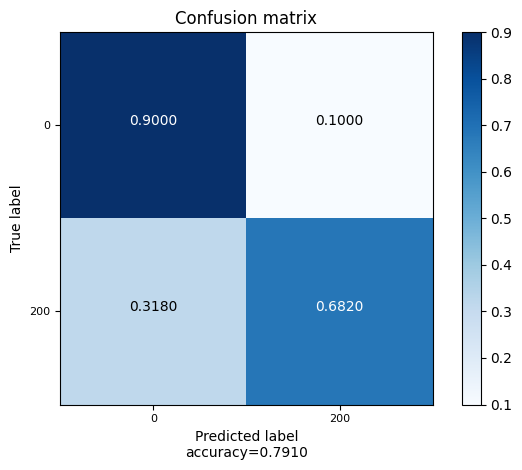

0

In [36]:
net_LCT.predict(gene_sim_test, model)
net_LCT.plot_cm(gene_sim_test.classes, text=True)